**Create en folder in this file**

C:\Users\narra\anaconda3\Scripts\conda.exe create --prefix C:\MurthyLab\segmentation\env python=3.9 -y

**Step 1: Activate Your Environment**

conda activate "C:\MurthyLab\segmentation\env"

**✅ Test OpenCV:**

In [1]:
import cv2
print("OpenCV Version:", cv2.__version__)

OpenCV Version: 4.6.0


**✅ Verify TensorFlow & PyTorch:**

In [9]:
import torch
import tensorflow as tf

print("PyTorch version:", torch.__version__)
print("Is CUDA available?", torch.cuda.is_available())
print("TensorFlow version:", tf.__version__)

PyTorch version: 2.3.1
Is CUDA available? False
TensorFlow version: 2.10.0


**✅ Run a Basic Image Load Test:**

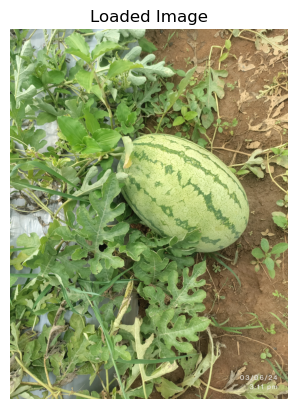

In [4]:
import cv2
import matplotlib.pyplot as plt

image_path = r"C:\MurthyLab\segmentation\data\Watermelon\IMG_20240603_151140.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis("off")
plt.title("Loaded Image")
plt.show()

In [14]:
!pip install torch torchvision numpy matplotlib opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)



This script sets up a PyTorch-based image processing or deep learning pipeline.

🔧 Libraries Used:
- os: For interacting with the file system
- torch, torch.nn, torch.optim: For building and training neural networks
- torchvision.transforms: For image preprocessing and augmentation
- numpy: For numerical computations
- cv2 (OpenCV): For image loading and manipulation
- matplotlib.pyplot: For visualizing images or training results
- torch.utils.data: For handling custom datasets and data loaders

👨‍💻 Expected Usage:
- Build custom datasets using `Dataset` class
- Apply transformations using `transforms`
- Use DataLoader for batching
- Build a model using `nn.Module`
- Train and evaluate using optimizers like `Adam` or `SGD`


In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


**SegmentationDataset:**

A custom PyTorch Dataset class for image segmentation tasks, specifically designed for binary classification 
(e.g., Good-to-Harvest vs Bad-to-Harvest).

**Inputs:**

- `image_folder`: Path to folder containing input images (.png)
- `mask_folder`: Path to folder containing corresponding ground truth masks (.png)

**Functionality:**

- Loads grayscale images and their corresponding masks
- Resizes both to 256x256 resolution
- Normalizes image pixel values to [0, 1]
- Converts mask into binary format: 1 = Good-to-Harvest, 0 = Not-Good
- Applies optional transformations
- Returns image and mask as PyTorch tensors with a channel dimension (1x256x256)

Used in training deep learning models like U-Net for semantic segmentation.


In [24]:
class SegmentationDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        self.image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
        self.mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256, 256)) / 255.0
        mask = cv2.resize(mask, (256, 256)) / 255.0

        # Convert mask to binary (0 = Bad to Harvest, 1 = Good to Harvest)
        mask = (mask > 0.5).astype("float32")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return torch.tensor(image).unsqueeze(0), torch.tensor(mask).unsqueeze(0)


UNet (Simplified Version) for Binary Image Segmentation in PyTorch

**Purpose:**

This class defines a U-Net architecture that performs **pixel-wise classification** — used in segmentation tasks 
(e.g., identifying "Good to Harvest" vs "Not Good" regions in an image).

**How It Works:**

1. **Encoder**: Extracts features using multiple convolution layers.
   - It learns patterns like edges, textures, and shapes.
   - Channels increase step by step: 1 → 64 → 128 → 256 → 512

2. **Bottleneck**: Deepest layer with 1024 channels.
   - It captures complex features from the input image.

3. **Decoder**: Reconstructs the output mask from features.
   - Channels decrease step by step: 1024 → 512 → 256 → 128 → 64

4. **Final Layer**: 
   - Outputs a single-channel prediction mask using a 1x1 convolution.
   - This mask shows which pixels belong to the target class (value near 1) and which do not (value near 0).

**Key Details:**

- Uses `conv_block()` to repeat Conv2D + ReLU twice in each stage.
- Input: grayscale image (1 channel)
- Output: segmentation mask (1 channel)

**Note:**

This version does **not include skip connections**, so it's a simpler version of the original U-Net.

In [25]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.dec4 = self.conv_block(1024, 512)
        self.dec3 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec1 = self.conv_block(128, 64)

        # Final Output Layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Bottleneck
        b = self.bottleneck(e4)

        # Decoder
        d4 = self.dec4(b)
        d3 = self.dec3(d4)
        d2 = self.dec2(d3)
        d1 = self.dec1(d2)

        return self.final(d1)

Model Initialization and Training Setup

**Device Selection:**

Automatically selects GPU (CUDA) if available, otherwise falls back to CPU.

**Model Setup:**

- Instantiates the UNet model and moves it to the selected device.

**Optimizer:**

- Uses the Adam optimizer for faster and adaptive gradient updates.
- Learning rate set to 0.001 (can be tuned based on performance).

**Loss Function: BCEWithLogitsLoss**

- This loss is used when you're doing **binary classification** for each pixel (i.e., mask prediction).
- It is best for segmentation tasks where the output mask contains only **0 (background)** and **1 (target)**.

Why use it?
- It **automatically applies a Sigmoid function** to the output of the model.
- Then it calculates the **Binary Cross Entropy (BCE)** between predicted and actual mask values.

So you don’t need to apply `Sigmoid` manually in the model’s output layer — it's already handled inside this loss!

**Summary:**

- Simple to use
- Good for binary segmentation (e.g., good-to-harvest vs not-good)
- Works well when model outputs are raw scores (called *logits*)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


**Custom Dataset for Image Segmentation (PyTorch)**

This class loads grayscale images and their corresponding segmentation masks from folders and prepares them 
for training a deep learning model like U-Net.

**Features:**

1. Loads image-mask pairs from two directories (`image_dir`, `mask_dir`)
2. Resizes both images and masks to a fixed size (default: 256x256)
3. Normalizes pixel values to the [0, 1] range
4. Converts each image and mask into a PyTorch tensor with a shape of [1, H, W]
5. Supports optional transformations (e.g., data augmentation)

**Output:**

- Returns a tuple: `(image_tensor, mask_tensor)`
- Both are tensors of shape `[1, 256, 256]` with float32 type

**Suitable For:**

- Binary segmentation tasks (e.g., Good-to-Harvest vs Not-Good)
- Any grayscale image-mask pair datasets



In [37]:
import os
import torch
from torch.utils.data import Dataset
import cv2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_size = target_size
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize images and masks to fixed size
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)
        
        # Normalize pixel values to [0, 1]
        image = image / 255.0
        mask = mask / 255.0
        
        # Convert to tensors and add channel dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # shape: [1, H, W]
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # shape: [1, H, W]
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


**U-Net Based Watermelon Segmentation (PyTorch)**

**Goal:**

Perform **binary image segmentation** to detect "Good-to-Harvest" vs "Not-Good" regions in watermelon images using a U-Net model.

**Code Structure:**

1. **Custom Dataset (WatermelonDataset)**:
   - Loads grayscale images and masks from folders.
   - Resizes to 256x256 and normalizes to [0, 1].
   - Returns image-mask tensors shaped [1, H, W].

2. **U-Net Architecture**:
   - 4 encoder blocks with max pooling.
   - Bottleneck layer.
   - 4 decoder blocks with skip connections and up-convolutions.
   - Final output layer with 1 channel (no sigmoid since using `BCEWithLogitsLoss`).

3. **Training Loop**:
   - Runs for a fixed number of epochs.
   - Uses Adam optimizer and `BCEWithLogitsLoss` (binary classification).
   - Moves data and model to GPU (if available).

**Dataset Path:**

- `image_dir` = C:\MurthyLab\segmentation\data\Watermelon
- `mask_dir`  = C:\MurthyLab\segmentation\data\masklabels

**Output:**

Prints average loss per epoch during training.

**Suitable For:**

- Binary segmentation tasks
- Medical imaging, plant disease segmentation, etc.


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

# --- Dataset ---
class WatermelonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, target_size=(256, 256), transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.target_size = target_size  # (width, height)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Read grayscale images
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize (width, height) using OpenCV
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)

        # Normalize to [0,1]
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Convert to tensor and add channel dimension: [C, H, W]
        image = torch.tensor(image).unsqueeze(0)  # shape: [1, H, W]
        mask = torch.tensor(mask).unsqueeze(0)    # shape: [1, H, W]

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# --- U-Net Model ---
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        e3 = self.enc3(p2)
        p3 = self.pool(e3)

        e4 = self.enc4(p3)
        p4 = self.pool(e4)

        b = self.bottleneck(p4)

        u4 = self.upconv4(b)
        c4 = torch.cat([u4, e4], dim=1)
        d4 = self.dec4(c4)

        u3 = self.upconv3(d4)
        c3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(c3)

        u2 = self.upconv2(d3)
        c2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(c2)

        u1 = self.upconv1(d2)
        c1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(c1)

        out = self.final(d1)
        return out


# --- Training setup ---
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


# --- Main ---
if __name__ == "__main__":
    image_dir = r"C:\MurthyLab\segmentation\data\Watermelon"
    mask_dir = r"C:\MurthyLab\segmentation\data\masklabels"
    batch_size = 4
    epochs = 5

    dataset = WatermelonDataset(image_dir, mask_dir, target_size=(256, 256))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        loss = train(model, dataloader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


Epoch 1/5, Loss: 0.4182
Epoch 2/5, Loss: 0.1358
Epoch 3/5, Loss: 0.1304
Epoch 4/5, Loss: 0.1305
Epoch 5/5, Loss: 0.1315


**Segmentation Evaluation Metrics (Binary Mask Evaluation)**

These functions compute standard evaluation metrics for binary segmentation tasks
(predicted masks vs. ground truth masks):

1.  **Accuracy**:
   - Measures overall correctness (how many pixels are classified correctly).
   - Formula: (TP + TN) / Total pixels

2. **IoU (Intersection over Union)**:
   - Measures overlap between prediction and ground truth.
   - Formula: IoU = Intersection / Union

3.  **Precision**:
   - Measures how many predicted positives are actually correct.
   - Formula: TP / (TP + FP)

4.  **Recall**:
   - Measures how many actual positives were captured.
   - Formula: TP / (TP + FN)

5.  **F1 Score**:
   - Harmonic mean of precision and recall (balance between them).
   - Formula: 2 * (Precision * Recall) / (Precision + Recall)

**Note:**

- `pred` and `mask` are PyTorch tensors with shape [B, 1, H, W] or [1, H, W].
- Threshold = 0.5 (default) is used to binarize predicted mask.
- `epsilon` is used to avoid division by zero.



In [6]:
def calculate_accuracy(pred, mask, threshold=0.5):
    pred_bin = (pred > threshold).float()
    correct = (pred_bin == mask).float()
    return correct.mean().item()

def calculate_iou(pred, mask, threshold=0.5, epsilon=1e-7):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * mask).sum()
    union = pred_bin.sum() + mask.sum() - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.item()

def calculate_precision(pred, mask, threshold=0.5, epsilon=1e-7):
    pred_bin = (pred > threshold).float()
    tp = (pred_bin * mask).sum()
    fp = (pred_bin * (1 - mask)).sum()
    precision = tp / (tp + fp + epsilon)
    return precision.item()

def calculate_recall(pred, mask, threshold=0.5, epsilon=1e-7):
    pred_bin = (pred > threshold).float()
    tp = (pred_bin * mask).sum()
    fn = ((1 - pred_bin) * mask).sum()
    recall = tp / (tp + fn + epsilon)
    return recall.item()

def calculate_f1_score(pred, mask, threshold=0.5, epsilon=1e-7):
    precision = calculate_precision(pred, mask, threshold, epsilon)
    recall = calculate_recall(pred, mask, threshold, epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return f1



**Final Evaluation Block (on entire dataset)**

This code evaluates the trained segmentation model using common binary classification metrics:

- Accuracy: Overall correctness of predicted pixels
- IoU (Jaccard Index): Measures overlap between predicted and ground truth masks
- Precision: How many predicted positives were actually positive
- Recall: How many actual positives were correctly predicted
- F1 Score: Harmonic mean of precision and recall

**Notes:**

- Uses sigmoid to convert model outputs to probability maps.
- Metrics are averaged across all images in the dataset.
- Ideal for validation or testing phase after training.


In [7]:
model.eval()
total_acc = 0
total_iou = 0
total_precision = 0
total_recall = 0
total_f1 = 0
count = 0

with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)

        for pred, mask in zip(preds, masks):
            acc = calculate_accuracy(pred, mask)
            iou = calculate_iou(pred, mask)
            precision = calculate_precision(pred, mask)
            recall = calculate_recall(pred, mask)
            f1 = calculate_f1_score(pred, mask)

            total_acc += acc
            total_iou += iou
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            count += 1

avg_acc = total_acc / count
avg_iou = total_iou / count
avg_precision = total_precision / count
avg_recall = total_recall / count
avg_f1 = total_f1 / count

print(f"✅ Accuracy: {avg_acc:.4f}")
print(f"📏 IoU: {avg_iou:.4f}")
print(f"🎯 Precision: {avg_precision:.4f}")
print(f"🔄 Recall: {avg_recall:.4f}")
print(f"🏆 F1 Score: {avg_f1:.4f}")


✅ Accuracy: 0.9715
📏 IoU: 0.0000
🎯 Precision: 0.0000
🔄 Recall: 0.0000
🏆 F1 Score: 0.0000


**Sample Prediction Visualization**

**This block:**

- Loads one image-mask pair from the dataset.
- Runs the trained model to predict the segmentation mask.
- Converts the model’s output (logits) to probabilities using sigmoid.
- Plots:
    1. The input image
    2. The ground truth mask
    3. The predicted mask from the model

**Purpose:**

Useful for visually verifying how well the model performs on a sample image.
Great for debugging and presentation.


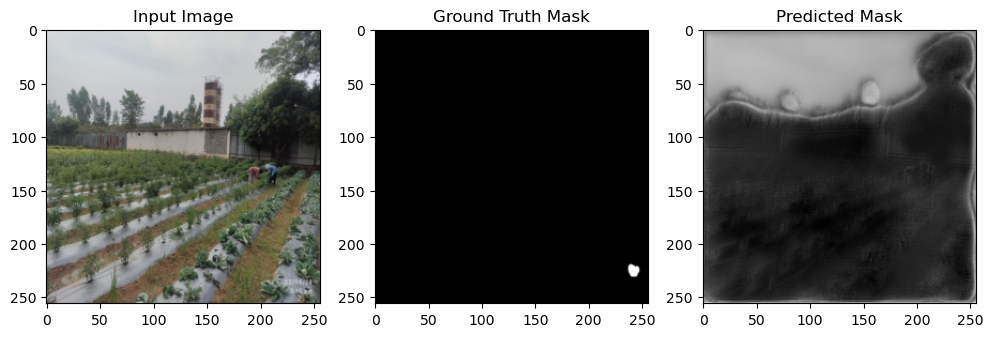

In [129]:
import matplotlib.pyplot as plt
import torch

# Load a sample image and mask
image, mask = dataset[0]

# Ensure tensors are correctly formatted
image = image.unsqueeze(0).to(device)  # Add batch dimension
model.eval()
with torch.no_grad():
    pred_mask = model(image)
    pred_mask = torch.sigmoid(pred_mask).cpu().numpy().squeeze()

# Adjust image shape for plotting
image_np = image.cpu().numpy().squeeze()
if image_np.shape[0] == 3:  # RGB image case (C, H, W)
    image_np = image_np.transpose(1, 2, 0)  # Convert to (H, W, C)

# Plot the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(image_np, cmap="gray" if image_np.ndim == 2 else None)

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(mask.numpy().squeeze(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap="gray")

plt.show()

Epoch 1/10, Loss: 0.8897
Epoch 2/10, Loss: 0.6931
Epoch 3/10, Loss: 0.6931
Epoch 4/10, Loss: 0.6931
Epoch 5/10, Loss: 0.6931
Epoch 6/10, Loss: 0.6931
Epoch 7/10, Loss: 0.6931
Epoch 8/10, Loss: 0.6931
Epoch 9/10, Loss: 0.6931
Epoch 10/10, Loss: 0.6931


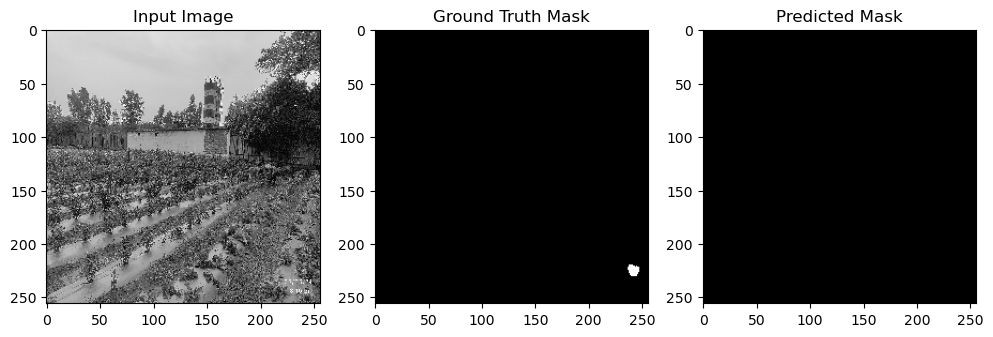

In [130]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# --- Dataset Class ---
class WatermelonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, target_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.target_size = target_size  # (width, height)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Load images in grayscale
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize images
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)

        # Normalize images
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Ensure mask is binary
        mask = np.round(mask)  # Converts to 0 or 1

        # Convert to PyTorch tensors
        image = torch.tensor(image).unsqueeze(0)  # Shape: [1, H, W]
        mask = torch.tensor(mask).unsqueeze(0)    # Shape: [1, H, W]

        return image, mask

# --- UNet Model ---
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        e3 = self.enc3(p2)
        p3 = self.pool(e3)

        e4 = self.enc4(p3)
        p4 = self.pool(e4)

        b = self.bottleneck(p4)

        u4 = self.upconv4(b)
        c4 = torch.cat([u4, e4], dim=1)
        d4 = self.dec4(c4)

        u3 = self.upconv3(d4)
        c3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(c3)

        u2 = self.upconv2(d3)
        c2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(c2)

        u1 = self.upconv1(d2)
        c1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(c1)

        out = torch.sigmoid(self.final(d1))  # Apply sigmoid activation
        return out

# --- Training Function ---
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# --- Visualization Function ---
def visualize_predictions(model, dataset, device):
    model.eval()
    image, mask = dataset[0]
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        pred_mask = model(image)
        pred_mask = pred_mask.cpu().numpy().squeeze()

    # Adjust image shape for plotting
    image_np = image.cpu().numpy().squeeze()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image_np, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask.numpy().squeeze(), cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap="gray")

    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    image_dir = r"C:\MurthyLab\segmentation\data\Watermelon"
    mask_dir = r"C:\MurthyLab\segmentation\data\masklabels"
    batch_size = 4
    epochs = 10

    dataset = WatermelonDataset(image_dir, mask_dir, target_size=(256, 256))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        loss = train(model, dataloader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    visualize_predictions(model, dataset, device)

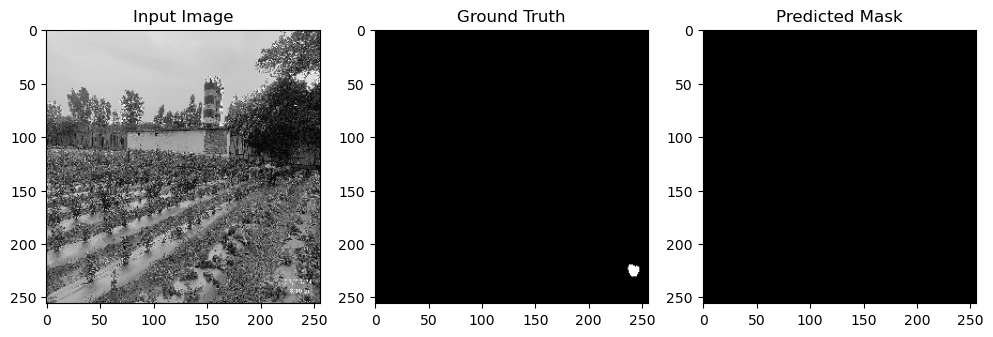

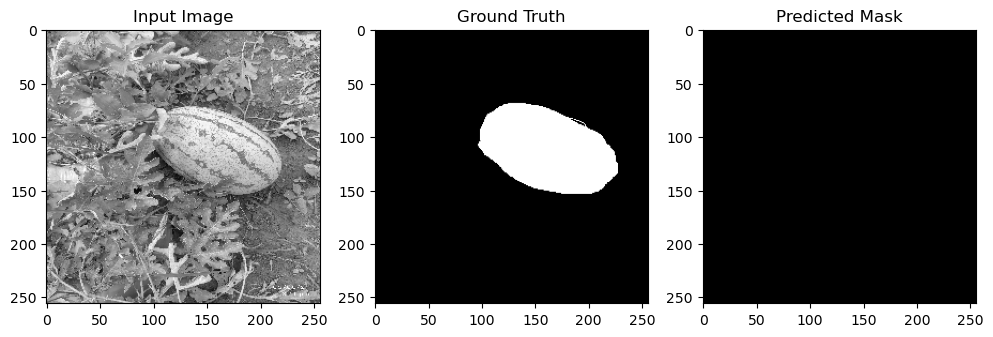

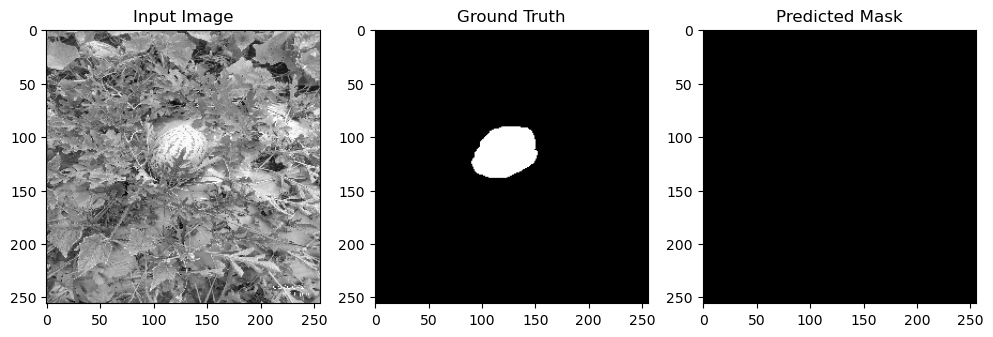

In [42]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i in range(3):  # visualize 3 samples
        image, mask = dataset[i]
        image = image.unsqueeze(0).to(device)  # add batch dim
        output = model(image)
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        true_mask = mask.squeeze().numpy()
        input_image = image.squeeze().cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_image, cmap='gray')
        plt.title("Input Image")
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask > 0.5, cmap='gray')  # binarize prediction
        plt.title("Predicted Mask")
        plt.show()


In [43]:
def calculate_accuracy(pred, mask):
    pred = (pred > 0.5).float()  # Binarize prediction
    correct = (pred == mask).float()
    acc = correct.sum() / correct.numel()
    return acc.item()

def calculate_iou(pred, mask):
    pred = (pred > 0.5).float()  # Binarize prediction
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() - intersection
    if union == 0:
        return 1.0  # perfect match
    else:
        return (intersection / union).item()


In [45]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, num=3):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = torch.sigmoid(model(images))

            for i in range(num):
                pred = outputs[i][0].cpu().numpy()
                true = masks[i][0].cpu().numpy()
                inp = images[i][0].cpu().numpy()

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Input")
                plt.imshow(inp, cmap='gray')
                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(true, cmap='gray')
                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred > 0.5, cmap='gray')
                plt.show()
            break


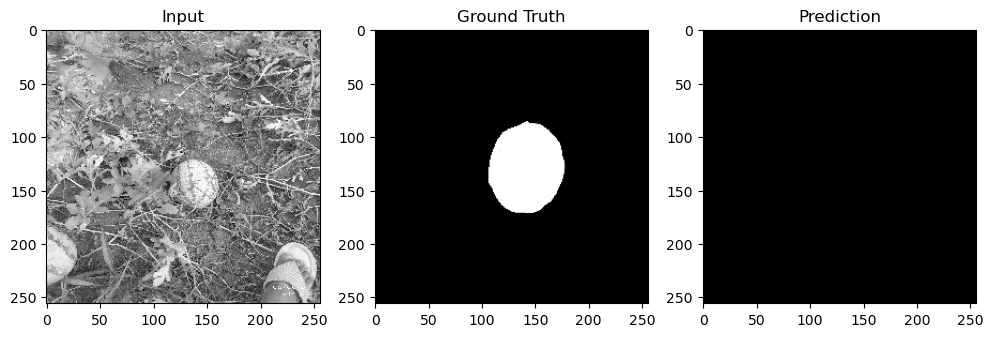

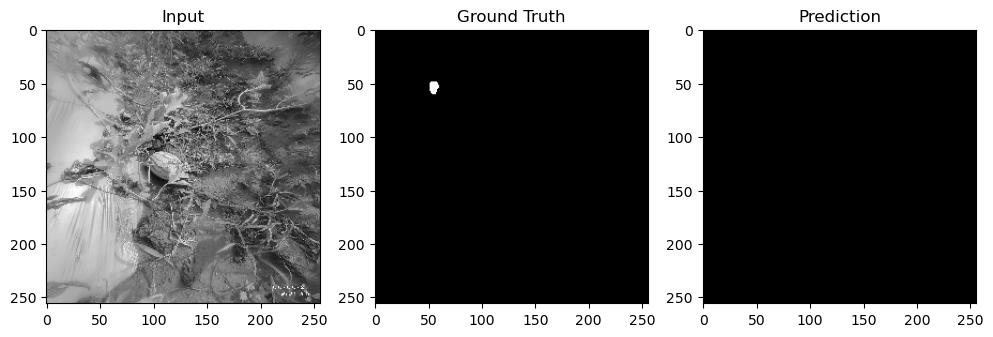

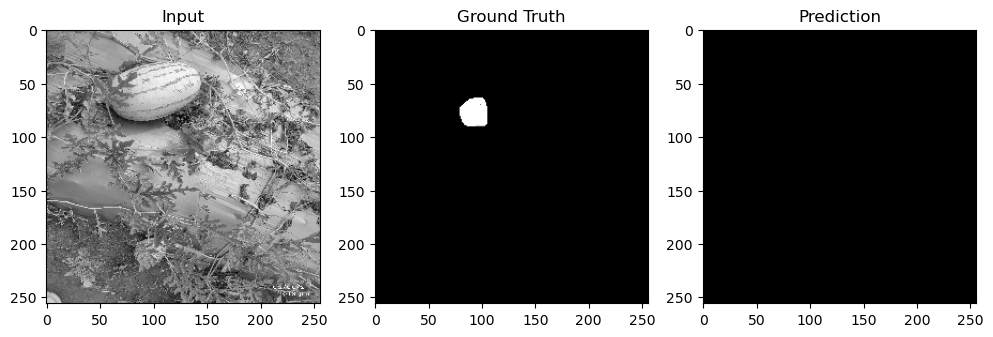

In [46]:
show_predictions(model, dataloader)


In [47]:
pos_weight = torch.tensor([5.0]).to(device)  # Tune this value
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [48]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, device, num_images=3):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = torch.sigmoid(model(images))  # Apply sigmoid to get probabilities

            for i in range(num_images):
                image = images[i][0].cpu().numpy()
                true_mask = masks[i][0].cpu().numpy()
                pred_mask = (outputs[i][0] > 0.5).float().cpu().numpy()  # Binarize

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Input Image")
                plt.imshow(image, cmap='gray')

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth Mask")
                plt.imshow(true_mask, cmap='gray')

                plt.subplot(1, 3, 3)
                plt.title("Predicted Mask")
                plt.imshow(pred_mask, cmap='gray')

                plt.tight_layout()
                plt.show()

            break  # Show only 1 batch


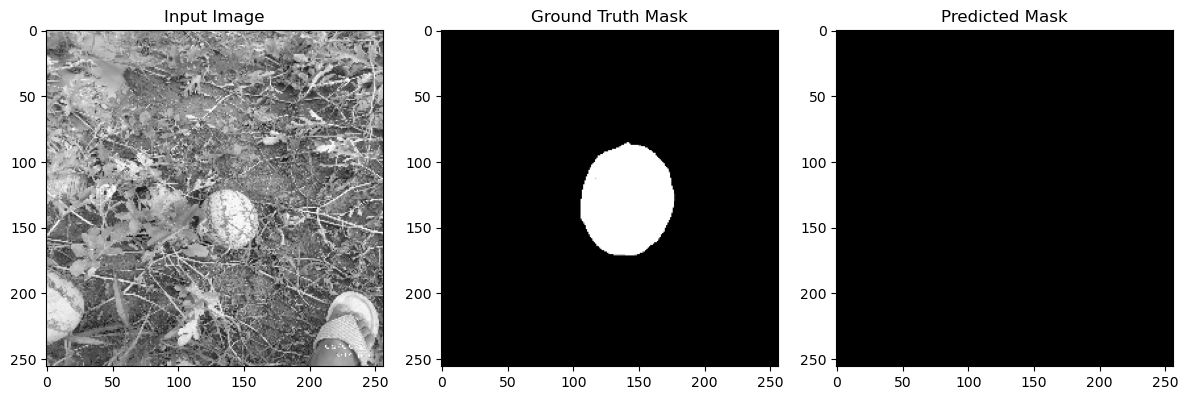

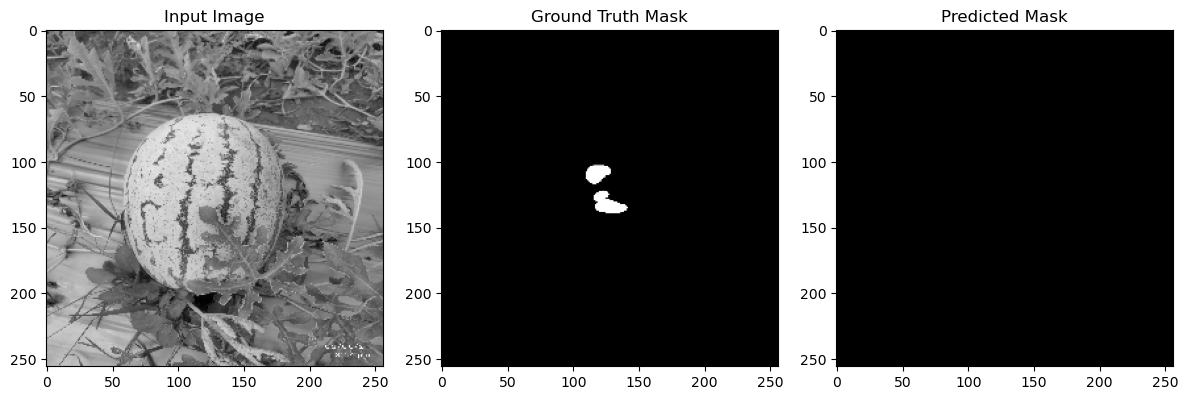

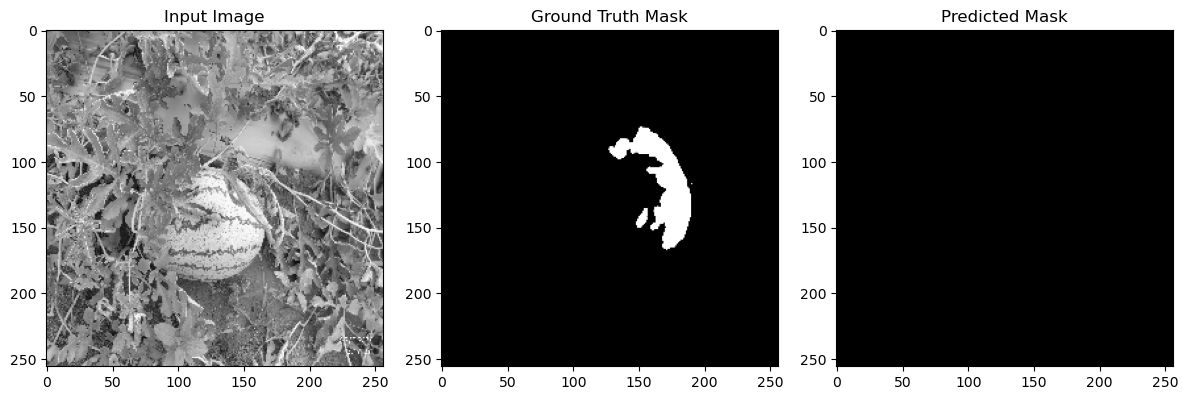

In [49]:
show_predictions(model, dataloader, device)


In [53]:
model.eval()
total_acc = 0
total_iou = 0
num_batches = 0

with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)

        acc, iou = compute_metrics(preds, masks, threshold=0.5)
        total_acc += acc
        total_iou += iou
        num_batches += 1

print(f"✅ Final Accuracy: {total_acc/num_batches:.4f}")
print(f"📏 Final IoU: {total_iou/num_batches:.4f}")


✅ Final Accuracy: 0.9715
📏 Final IoU: 0.0000



Description of Multiple Labels and Ground Truth Mask Mismatch

In this segmentation task, each input image may contain multiple labels or classes (for example, different parts 
of the watermelon, defects, or various object types). However, the current dataset provides a single binary 
mask per image representing only one class at a time.

This causes the following issues:

1. **Ground Truth Mask Limitation:**  
   The mask is binary (0 or 1) and can only represent one class per pixel. When multiple labels are present in the 
   image, the mask does not fully represent all the classes, leading to partial or incomplete ground truth.

2. **Prediction vs. Ground Truth Mismatch:**  
   The model tries to predict the entire segmentation mask for all labels combined. Since the ground truth mask 
   only covers one label, the predicted mask and ground truth mask shapes and content do not match well, resulting 
   in inaccurate visualizations and poor quantitative results.

3. **Training Confusion:**  
   The model receives inconsistent supervision signals because the ground truth does not comprehensively represent 
   all objects or labels in the image, making it difficult for the model to learn proper segmentation boundaries.


**Summary:**

When images contain multiple labels but the ground truth mask is binary and limited to one label, it causes a mismatch 
between predicted and true masks. This mismatch results in poor training performance and visualization errors. Proper 
dataset preparation and suitable model/loss design are necessary to handle multiple labels effectively.


Note on High Accuracy but Zero IoU

✅ Final Accuracy: 0.9715  
📏 Final IoU: 0.0000  

This often happens when the model predicts almost all pixels as background (or the dominant class), 
which leads to a high pixel-wise accuracy because most pixels belong to background.

However, the Intersection over Union (IoU) metric measures the overlap between predicted and ground truth masks 
for the *foreground* class. If the model completely misses the object regions (predicts none or very few foreground pixels),  
IoU becomes zero or very low.